# Labor 2 - Elektrokardiografie (EKG)
## Biosignale Praktikum

**Gruppe:** B6

**Datum:** 12.12.2025


**Teilnehmer:**
- Person 1: [Lukas Koehler] - [Geschlecht: m]
- Person 2: [Liliana Escobar] - [Geschlecht: w]
- Person 3: [Simon Schwarzer] - [Geschlecht: m]

---

## Aufgabenübersicht

Dieses Notebook bearbeitet folgende Aufgaben:

**Aufgabe 3**: EKG-Rohdaten (5 Sekunden gefiltert) mit P-QRS-T Markierung

**Aufgabe 5**: R-Zacken Detektion und Visualisierung

**Aufgabe 6**: Herzfrequenz und HRV für alle 3 Teilnehmer

**Aufgabe 7**: Klassenweite Datenanalyse (Histogramme)

**Aufgabe 8**: Bewegungsexperiment - vollständige Herzfrequenz

**Aufgabe 9**: Ramp Phase (0-3 Min) - Herzfrequenzanstieg

**Aufgabe 10**: Recovery Phase (3-7 Min) - Herzfrequenzerholung

**Aufgabe 11**: Energieverbrauch über Zeit

**Aufgabe 12**: Gesamter Energieverbrauch in verschiedenen Einheiten

## Bibliotheken importieren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import Lab2Functions as ekg

# Plot-Einstellungen
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✓ Alle Bibliotheken erfolgreich importiert")

✓ Alle Bibliotheken erfolgreich importiert


## Konstanten und Parameter

In [2]:
# Sampling-Parameter
SAMPLING_RATE = 1000  # Hz (aus serialRead.ipynb)

# Filter-Parameter (später anpassen!)
WN_HIGHFREQ = 0.08  # Für ~40 Hz cutoff (zum Entfernen von 50 Hz Rauschen)
WN_HR_SMOOTH = 0.01  # Für Herzfrequenz-Glättung

# R-Wave Detection Parameter
HEIGHT_THRESHOLD = 0.4  # Für d_ecg_peaks()
DISTANCE_THRESHOLD = 0.5  # Für d_ecg_peaks()

# Teilnehmer-Info (für Energieberechnung)
PERSON1_AGE = 20  
PERSON1_WEIGHT = 104  # kg 
PERSON1_HEIGHT = 186  # cm 
PERSON1_SEX = 'male' 

PERSON2_AGE = 21
PERSON2_WEIGHT = 70
PERSON2_HEIGHT = 171
PERSON2_SEX = 'female'

PERSON3_AGE = 24
PERSON3_WEIGHT = 85
PERSON3_HEIGHT = 195
PERSON3_SEX = 'female'


print(f"Sampling Rate: {SAMPLING_RATE} Hz")
print(f"Nyquist Frequency: {SAMPLING_RATE/2} Hz")

Sampling Rate: 1000 Hz
Nyquist Frequency: 500.0 Hz


---
# 1. Daten laden

## 1.1 Ruhe-Experimente (3 Teilnehmer)

**⚠️ ERFORDERLICH:** Führt für jeden Teilnehmer ein 10-minütiges Ruhe-EKG durch.

**Hardware Setup:**
- Weiße Elektrode: Manubrium
- Rote Elektrode: V6 (linke Seite)
- Schwarze Elektrode: C7 (Referenz, Nacken)

**Datenaufnahme:**
1. `Lab2Code1.ino` auf Arduino hochladen
2. `serialRead.ipynb` öffnen
3. `T_RECORD = 10` setzen (10 Minuten)
4. COM-Port anpassen
5. Script starten → speichert als `arduino_log.csv`
6. Umbenennen zu `rest_person1.csv`, `rest_person2.csv`, `rest_person3.csv`

In [3]:
# Laden der Ruhe-Daten für alle 3 Teilnehmer

def load_ecg_data(filename, sampling_rate=SAMPLING_RATE):
    """Lädt EKG-Daten aus CSV und erstellt Zeitachse"""
    try:
        # CSV Format aus serialRead.ipynb: index;value
        df = pd.read_csv(filename, sep=';', header=0, names=['index', 'ECG'])
        
        # Zeitachse erstellen
        df['Time'] = df['index'] / sampling_rate
        
        print(f"✓ {filename} geladen: {len(df)} Samples, {df['Time'].iloc[-1]:.1f} Sekunden")
        return df
    
    except FileNotFoundError:
        print(f"❌ FEHLER: {filename} nicht gefunden!")
        print(f"   Bitte Experiment durchführen und Datei erstellen.")
        return None

# Daten laden
print("=== Lade Ruhe-Experimente ===")
df_rest1 = load_ecg_data('lukas_arduino_log.csv')
df_rest2 = load_ecg_data('lili_arduino_log.csv')
df_rest3 = load_ecg_data('simon_arduino_ruhe.csv')

# Prüfen ob alle Daten vorhanden sind
rest_data_complete = all([df_rest1 is not None, df_rest2 is not None, df_rest3 is not None])
if rest_data_complete:
    print("\n✅ Alle Ruhe-Daten erfolgreich geladen!")
else:
    print("\n⚠️ Nicht alle Ruhe-Daten vorhanden - einige Analysen werden übersprungen")

=== Lade Ruhe-Experimente ===
✓ lukas_arduino_log.csv geladen: 447668 Samples, 447.7 Sekunden
✓ lili_arduino_log.csv geladen: 598618 Samples, 598.6 Sekunden
✓ simon_arduino_ruhe.csv geladen: 598638 Samples, 598.6 Sekunden

✅ Alle Ruhe-Daten erfolgreich geladen!


## 1.2 Bewegungs-Experiment (1 Teilnehmer)

**⚠️ ERFORDERLICH:** Ein Teilnehmer macht das Ergometer-Experiment.

**Protokoll:**
- 0-2 Min: Ruhe (sitzen, nicht treten)
- 2-5 Min: Konstante Leistung (mittlere bis schwere Anstrengung)
- 5-10 Min: Recovery (stoppen, erholen)

**Total:** 10 Minuten

**Datenaufnahme:** Wie bei Ruhe-Experimenten, speichern als `exercise_person1.csv`

In [4]:
print("=== Lade Bewegungs-Experiment ===")
df_exercise = load_ecg_data('arduino_log_Belastung_Lukas.csv')

if df_exercise is not None:
    print("\n✅ Bewegungs-Daten erfolgreich geladen!")
    
    # Experiment-Phasen definieren
    REST_PHASE = (0, 120)  # 0-2 Min
    RAMP_PHASE = (120, 300)  # 2-5 Min
    RECOVERY_PHASE = (300, 600)  # 5-10 Min
    
    print(f"\nExperiment-Phasen:")
    print(f"  Rest: {REST_PHASE[0]}-{REST_PHASE[1]}s")
    print(f"  Ramp: {RAMP_PHASE[0]}-{RAMP_PHASE[1]}s")
    print(f"  Recovery: {RECOVERY_PHASE[0]}-{RECOVERY_PHASE[1]}s")
else:
    print("\n⚠️ Bewegungs-Daten nicht vorhanden - entsprechende Aufgaben werden übersprungen")

=== Lade Bewegungs-Experiment ===
✓ arduino_log_Belastung_Lukas.csv geladen: 478599 Samples, 478.6 Sekunden

✅ Bewegungs-Daten erfolgreich geladen!

Experiment-Phasen:
  Rest: 0-120s
  Ramp: 120-300s
  Recovery: 300-600s


---
# 2. Signal-Filterung

## 2.1 Hochfrequenz-Filter (50 Hz Netzbrummen entfernen)

**Dokumentation (Aufgabe im Bericht):**
- Sampling Rate: 1000 Hz
- Nyquist Frequenz: 500 Hz
- Ziel: 50 Hz Rauschen entfernen
- Cutoff: ~40 Hz → Wn = 0.08-0.1

**TODO:** Verschiedene Wn-Werte testen und besten auswählen!

In [5]:
def filter_ecg_signal(ecg_data, wn=WN_HIGHFREQ, order=4):
    """
    Filtert EKG-Signal mit Butterworth Low-Pass Filter
    
    Parameters:
    -----------
    ecg_data : array
        Rohdaten des EKG-Signals
    wn : float
        Normalisierte Cutoff-Frequenz (0-1, wobei 1 = Nyquist)
    order : int
        Filter-Ordnung
    
    Returns:
    --------
    ecg_filtered : array
        Gefiltertes EKG-Signal
    """
    b, a = sp.butter(order, wn, 'low', analog=False)
    ecg_filtered = sp.filtfilt(b, a, ecg_data)
    return ecg_filtered

# Test mit verschiedenen Wn-Werten (zum Optimieren)
def test_filter_values(ecg_data, time, wn_values=[0.06, 0.08, 0.10, 0.12]):
    """Visualisiert verschiedene Filter-Einstellungen"""
    fig, axes = plt.subplots(len(wn_values) + 1, 1, figsize=(14, 3*len(wn_values)))
    
    # Original
    axes[0].plot(time, ecg_data, linewidth=0.8)
    axes[0].set_title('Original (ungefiltert)')
    axes[0].set_ylabel('EKG Signal')
    axes[0].grid(True, alpha=0.3)
    
    # Verschiedene Filter
    for i, wn in enumerate(wn_values):
        filtered = filter_ecg_signal(ecg_data, wn=wn)
        cutoff_hz = wn * (SAMPLING_RATE / 2)
        axes[i+1].plot(time, filtered, linewidth=0.8)
        axes[i+1].set_title(f'Gefiltert: Wn={wn:.2f} (Cutoff ~{cutoff_hz:.1f} Hz)')
        axes[i+1].set_ylabel('EKG Signal')
        axes[i+1].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Zeit (s)')
    plt.tight_layout()
    return fig

print("✓ Filter-Funktionen definiert")

✓ Filter-Funktionen definiert


=== Teste verschiedene Filter-Einstellungen ===
Zeige 5 Sekunden der Daten...



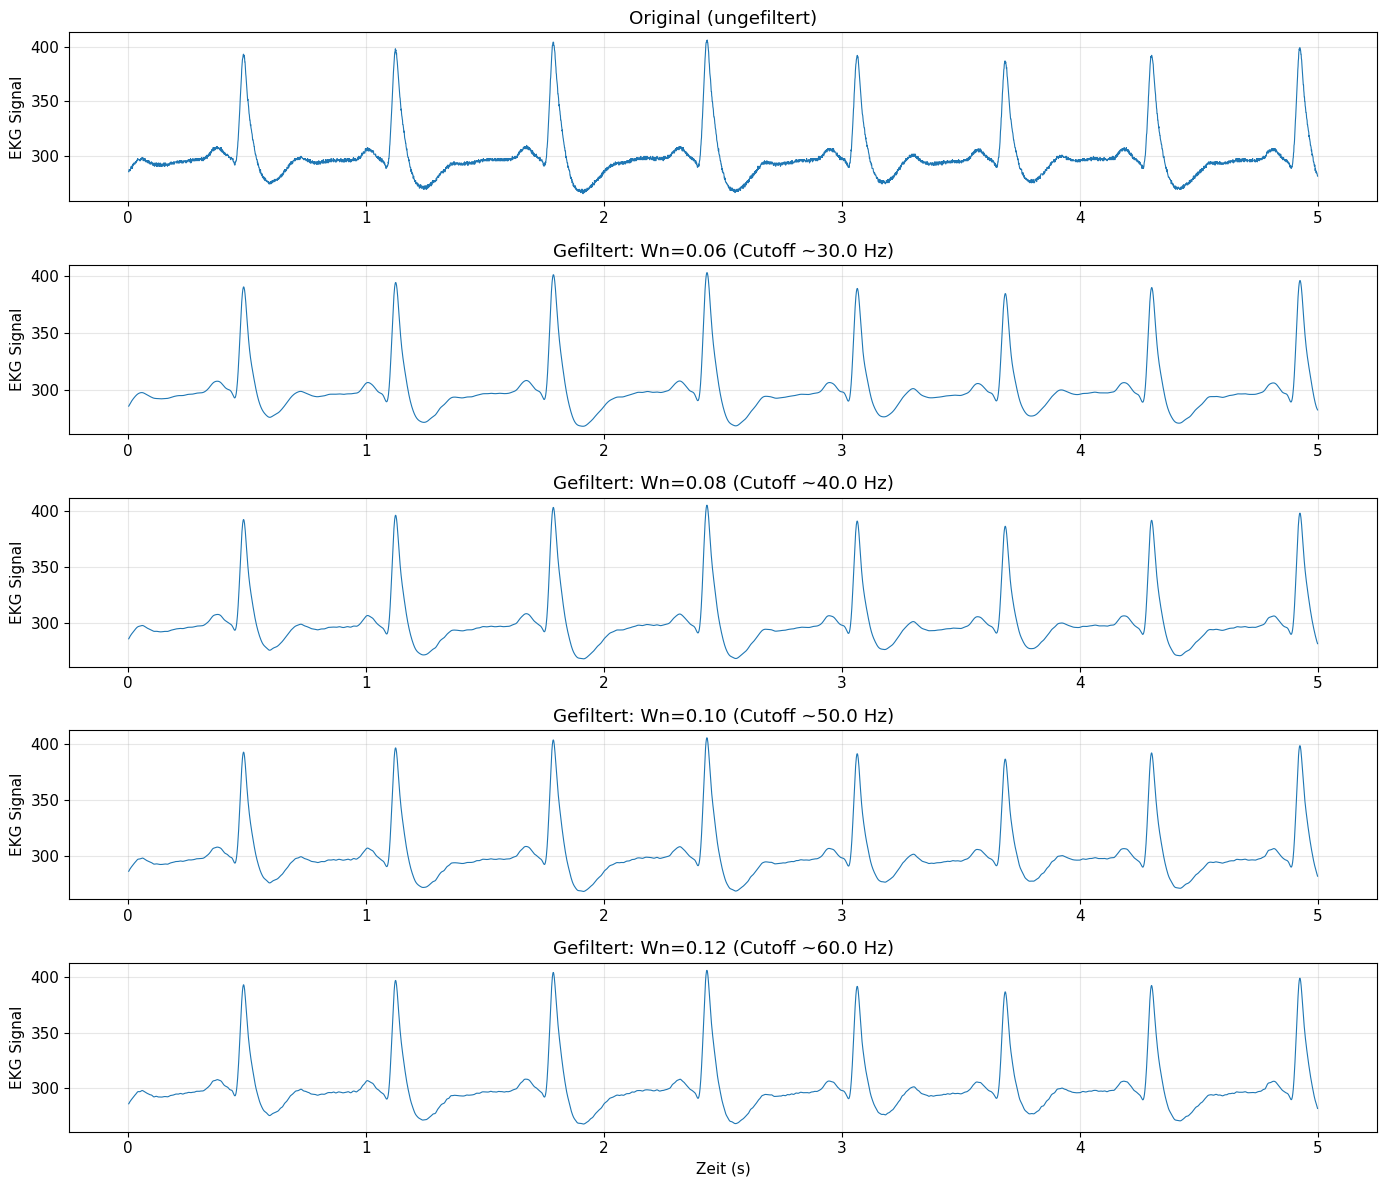


📝 TODO: Wähle den besten Wn-Wert und dokumentiere im Bericht:
   - Welcher Wn-Wert wurde gewählt?
   - Warum dieser Wert? (Balance: Rauschen entfernen vs. Signal erhalten)


In [6]:
# Filter testen (nur wenn Daten vorhanden)
if df_rest1 is not None:
    print("=== Teste verschiedene Filter-Einstellungen ===")
    print("Zeige 5 Sekunden der Daten...\n")
    
    # Nur erste 5 Sekunden zeigen
    mask = df_rest1['Time'] <= 5.0
    test_data = df_rest1[mask]['ECG'].values
    test_time = df_rest1[mask]['Time'].values
    
    fig = test_filter_values(test_data, test_time)
    plt.savefig('Filter_Comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📝 TODO: Wähle den besten Wn-Wert und dokumentiere im Bericht:")
    print("   - Welcher Wn-Wert wurde gewählt?")
    print("   - Warum dieser Wert? (Balance: Rauschen entfernen vs. Signal erhalten)")
else:
    print("⚠️ Übersprungen - Keine Daten vorhanden")

In [7]:
# Filter auf alle Datensätze anwenden
print("=== Wende Filter auf alle Datensätze an ===")

if df_rest1 is not None:
    df_rest1['ECG_filtered'] = filter_ecg_signal(df_rest1['ECG'].values, wn=WN_HIGHFREQ)
    print("✓ Person 1 gefiltert")

if df_rest2 is not None:
    df_rest2['ECG_filtered'] = filter_ecg_signal(df_rest2['ECG'].values, wn=WN_HIGHFREQ)
    print("✓ Person 2 gefiltert")

if df_rest3 is not None:
    df_rest3['ECG_filtered'] = filter_ecg_signal(df_rest3['ECG'].values, wn=WN_HIGHFREQ)
    print("✓ Person 3 gefiltert")

if df_exercise is not None:
    df_exercise['ECG_filtered'] = filter_ecg_signal(df_exercise['ECG'].values, wn=WN_HIGHFREQ)
    print("✓ Bewegungs-Daten gefiltert")

print("\n✅ Alle verfügbaren Daten gefiltert!")

=== Wende Filter auf alle Datensätze an ===
✓ Person 1 gefiltert
✓ Person 2 gefiltert
✓ Person 3 gefiltert
✓ Bewegungs-Daten gefiltert

✅ Alle verfügbaren Daten gefiltert!


---
# Aufgabe 3: EKG-Rohdaten mit P-QRS-T Markierung

**Anforderung:**
- Plot: ~5 Sekunden gefiltertes EKG für alle 3 Teilnehmer
- Für einen Teilnehmer: P-Welle, QRS-Komplex, T-Welle markieren
- Physiologische Erklärung im Bericht

**Punkte:** 3 (1 Plot + Markierungen + 1 Paragraph Erklärung)

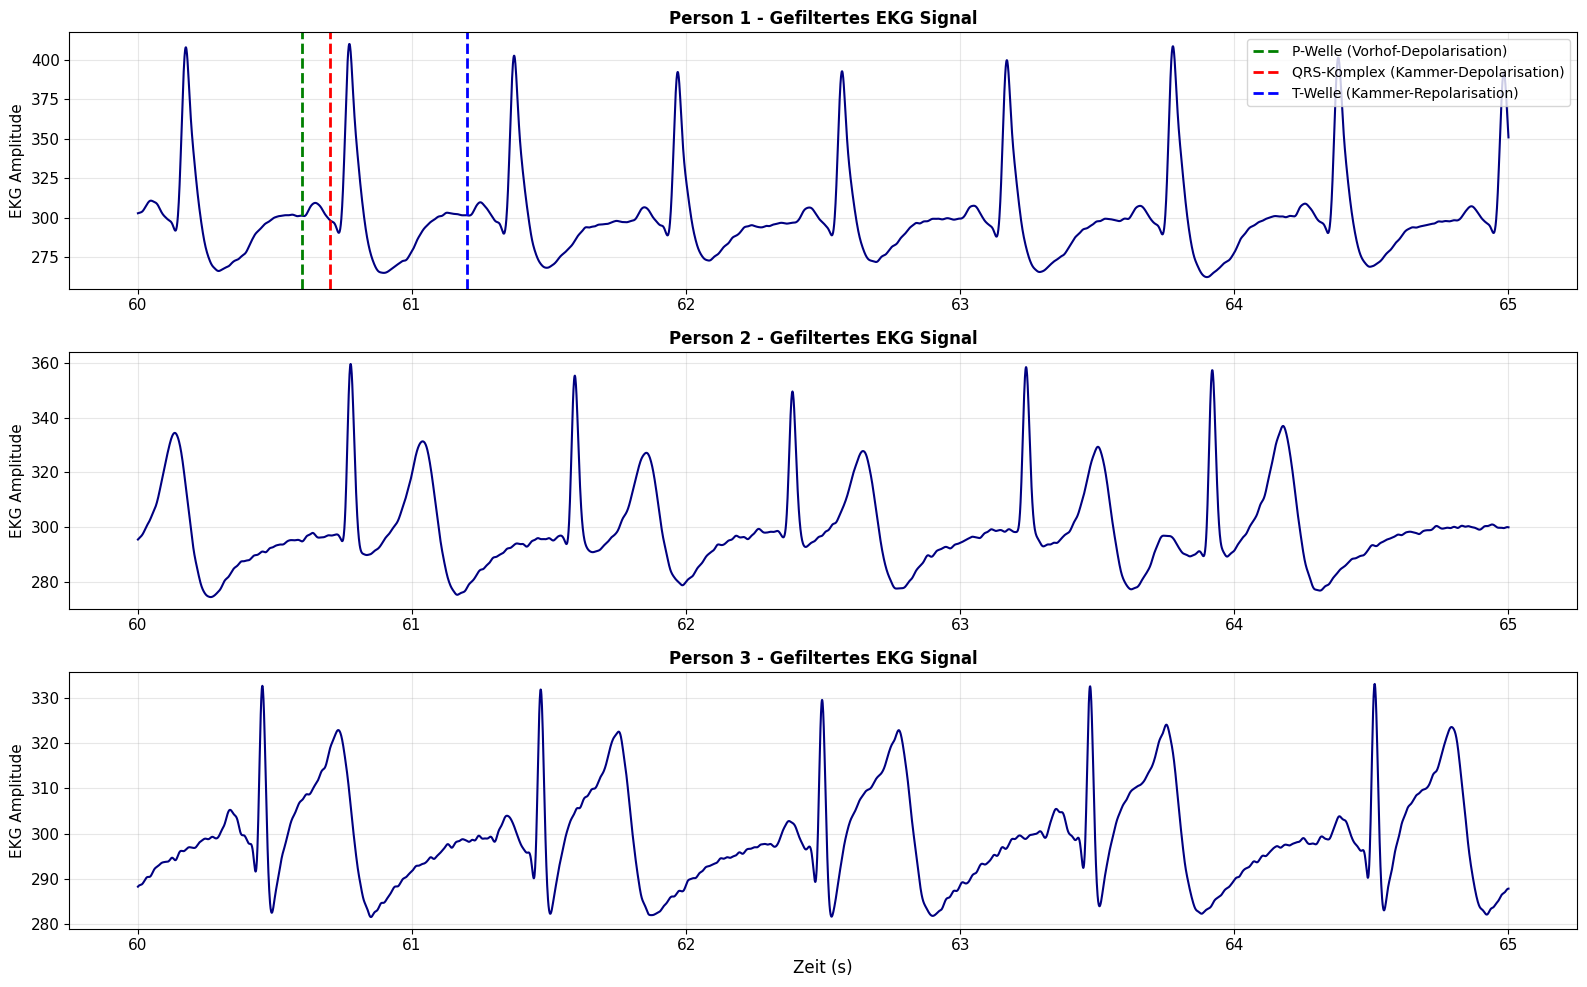


📝 TODO für Bericht:
   1. P-Welle, QRS-Komplex, T-Welle Positionen oben anpassen
   2. Physiologische Erklärung schreiben (1 Paragraph):
      - P-Welle: Vorhof-Depolarisation (atriale Kontraktion)
      - QRS: Kammer-Depolarisation (ventrikuläre Kontraktion)
      - T-Welle: Kammer-Repolarisation (ventrikuläre Entspannung)


In [8]:
if rest_data_complete:
    fig, axes = plt.subplots(3, 1, figsize=(16, 10))
    
    # Parameter für alle Plots
    time_start = 60  # Start bei 60s (stabiles Signal)
    time_end = 65    # 5 Sekunden zeigen
    
    datasets = [df_rest1, df_rest2, df_rest3]
    names = ['Person 1', 'Person 2', 'Person 3']
    
    for i, (df, name) in enumerate(zip(datasets, names)):
        # 5 Sekunden extrahieren
        mask = (df['Time'] >= time_start) & (df['Time'] <= time_end)
        time_segment = df[mask]['Time'].values
        ecg_segment = df[mask]['ECG_filtered'].values
        
        # Plot
        axes[i].plot(time_segment, ecg_segment, linewidth=1.5, color='navy')
        axes[i].set_ylabel('EKG Amplitude', fontsize=11)
        axes[i].set_title(f'{name} - Gefiltertes EKG Signal', fontsize=12, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        
        # Nur für Person 1: P-QRS-T Markierungen
        if i == 0:
            # TODO: Manuell anpassen nach Inspektion der Daten!
            # Finde einen klaren Herzzyklus und markiere
            
            # Beispiel-Positionen (MÜSSEN ANGEPASST WERDEN!)
            p_wave_time = time_start + 0.6  # Beispiel
            qrs_time = time_start + 0.70    # Beispiel
            t_wave_time = time_start + 1.2 # Beispiel
            
            # Markierungen
            axes[i].axvline(p_wave_time, color='green', linestyle='--', 
                           linewidth=2, label='P-Welle (Vorhof-Depolarisation)')
            axes[i].axvline(qrs_time, color='red', linestyle='--', 
                           linewidth=2, label='QRS-Komplex (Kammer-Depolarisation)')
            axes[i].axvline(t_wave_time, color='blue', linestyle='--', 
                           linewidth=2, label='T-Welle (Kammer-Repolarisation)')
            axes[i].legend(loc='upper right', fontsize=10)
    
    axes[2].set_xlabel('Zeit (s)', fontsize=12)
    plt.tight_layout()
    plt.savefig('Aufgabe3_EKG_5Sekunden_PQRSTMarkierung.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📝 TODO für Bericht:")
    print("   1. P-Welle, QRS-Komplex, T-Welle Positionen oben anpassen")
    print("   2. Physiologische Erklärung schreiben (1 Paragraph):")
    print("      - P-Welle: Vorhof-Depolarisation (atriale Kontraktion)")
    print("      - QRS: Kammer-Depolarisation (ventrikuläre Kontraktion)")
    print("      - T-Welle: Kammer-Repolarisation (ventrikuläre Entspannung)")
else:
    print("⚠️ Aufgabe 3 übersprungen - Ruhe-Daten fehlen")

---
# 3. R-Zacken Detektion

## 3.1 R-Wave Detection Algorithmus (Lab2Functions.py)

**3-Schritt Prozess:**
1. `decg_peaks()`: Finde Peaks der Ableitung
2. `d_ecg_peaks()`: Filtere falsche Peaks (Threshold + Distanz)
3. `Rwave_peaks()`: Finde echte R-Zacken im Original-Signal

In [9]:
def detect_r_waves(ecg_filtered, time, 
                   height_threshold=HEIGHT_THRESHOLD, 
                   distance_threshold=DISTANCE_THRESHOLD):
    """
    Detektiert R-Zacken im EKG-Signal
    
    Parameters:
    -----------
    ecg_filtered : array
        Gefiltertes EKG-Signal
    time : pd.Series
        Zeitachse
    height_threshold : float
        Threshold für Höhe (0.4 empfohlen)
    distance_threshold : float
        Threshold für Distanz (0.5 empfohlen)
    
    Returns:
    --------
    rwave_times : pd.DataFrame
        Zeitpunkte der R-Zacken
    """
    # Schritt 1: Peaks der Ableitung
    d_ecg, peaks_d_ecg = ekg.decg_peaks(ecg_filtered, time)
    
    # Schritt 2: Falsche Peaks entfernen
    rwave_peaks_d_ecg, threshold = ekg.d_ecg_peaks(
        d_ecg, peaks_d_ecg, time, 
        height_threshold, distance_threshold
    )
    
    # Schritt 3: Echte R-Zacken finden
    rwave_times = ekg.Rwave_peaks(
        ecg_filtered, d_ecg, rwave_peaks_d_ecg, time
    )
    
    return rwave_times

print("✓ R-Wave Detection Funktion definiert")

✓ R-Wave Detection Funktion definiert


In [10]:
# R-Zacken für alle Datensätze detektieren
print("=== Detektiere R-Zacken ===")

if df_rest1 is not None:
    rwave1 = detect_r_waves(df_rest1['ECG_filtered'].values, df_rest1['Time'])
    print(f"✓ Person 1: {len(rwave1)} R-Zacken gefunden")
else:
    rwave1 = None

if df_rest2 is not None:
    rwave2 = detect_r_waves(df_rest2['ECG_filtered'].values, df_rest2['Time'])
    print(f"✓ Person 2: {len(rwave2)} R-Zacken gefunden")
else:
    rwave2 = None

if df_rest3 is not None:
    rwave3 = detect_r_waves(df_rest3['ECG_filtered'].values, df_rest3['Time'])
    print(f"✓ Person 3: {len(rwave3)} R-Zacken gefunden")
else:
    rwave3 = None

if df_exercise is not None:
    rwave_exercise = detect_r_waves(df_exercise['ECG_filtered'].values, df_exercise['Time'])
    print(f"✓ Bewegung: {len(rwave_exercise)} R-Zacken gefunden")
else:
    rwave_exercise = None

print("\n✅ R-Zacken Detektion abgeschlossen!")

=== Detektiere R-Zacken ===
✓ Person 1: 674 R-Zacken gefunden
✓ Person 2: 640 R-Zacken gefunden
✓ Person 3: 606 R-Zacken gefunden
✓ Bewegung: 1207 R-Zacken gefunden

✅ R-Zacken Detektion abgeschlossen!


---
# Aufgabe 5: R-Zacken Visualisierung

**Anforderung:**
- Plot: 5 Sekunden gefiltertes EKG von einem Teilnehmer
- R-Zacken mit Labels markieren

**Punkte:** 1 (1 Plot)

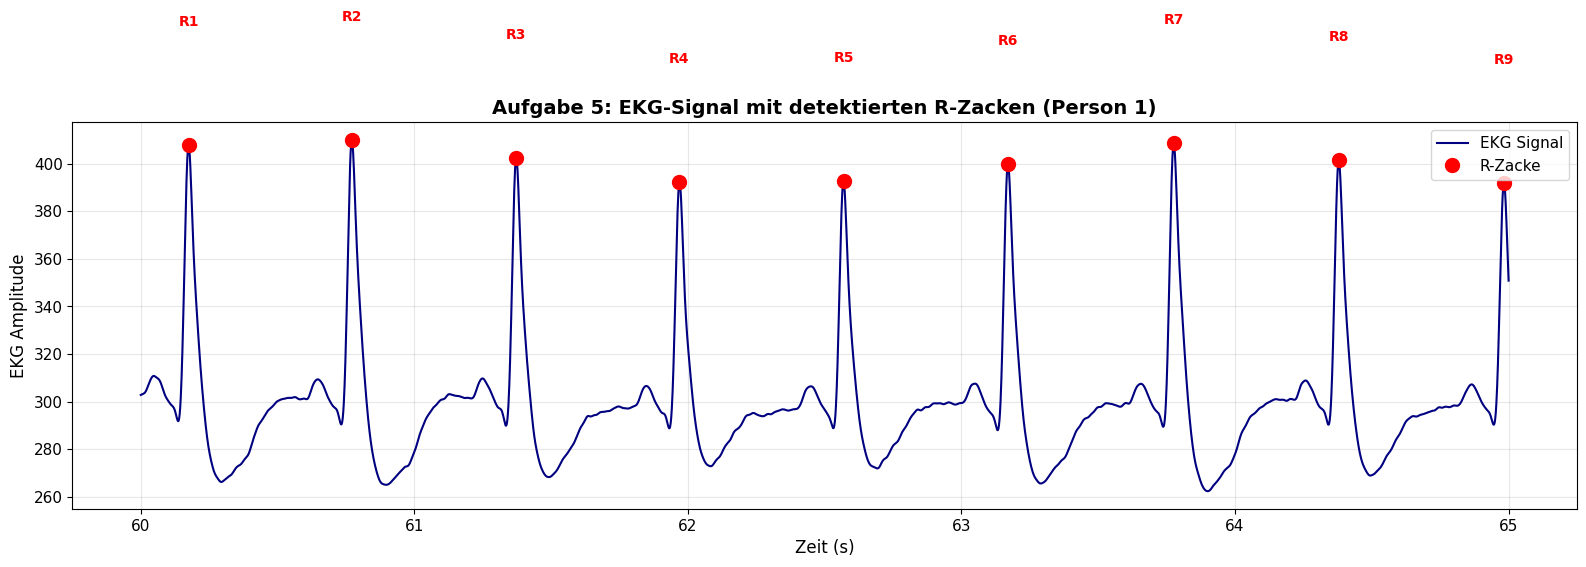

✓ Plot erstellt: 9 R-Zacken in 5 Sekunden
  Durchschnittliche Herzfrequenz: 108.0 bpm


In [11]:
if df_rest1 is not None and rwave1 is not None:
    # 5 Sekunden extrahieren (ab 60s für stabiles Signal)
    time_start = 60
    time_end = 65
    
    mask = (df_rest1['Time'] >= time_start) & (df_rest1['Time'] <= time_end)
    time_segment = df_rest1[mask]['Time'].values
    ecg_segment = df_rest1[mask]['ECG_filtered'].values
    
    # R-Zacken in diesem Zeitfenster
    # Handle both DataFrame and array
    if isinstance(rwave1, pd.DataFrame):
        rwave_mask = (rwave1['Time'] >= time_start) & (rwave1['Time'] <= time_end)
        rwave_times_segment = rwave1[rwave_mask]['Time'].values
    else:
        rwave_mask = (rwave1 >= time_start) & (rwave1 <= time_end)
        rwave_times_segment = rwave1[rwave_mask]
    
    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(time_segment, ecg_segment, linewidth=1.5, color='navy', label='EKG Signal')
    
    # R-Zacken markieren
    for i, rwave_time in enumerate(rwave_times_segment):
        # Finde EKG-Wert an dieser Zeit
        idx = np.argmin(np.abs(time_segment - rwave_time))
        ecg_value = ecg_segment[idx]
        
        plt.plot(rwave_time, ecg_value, 'ro', markersize=10, 
                label='R-Zacke' if i == 0 else '')
        plt.text(rwave_time, ecg_value + 50, f'R{i+1}', 
                ha='center', fontsize=10, fontweight='bold', color='red')
    
    plt.xlabel('Zeit (s)', fontsize=12)
    plt.ylabel('EKG Amplitude', fontsize=12)
    plt.title('Aufgabe 5: EKG-Signal mit detektierten R-Zacken (Person 1)', 
             fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('Aufgabe5_RZacken_Detektion.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Plot erstellt: {len(rwave_times_segment)} R-Zacken in 5 Sekunden")
    print(f"  Durchschnittliche Herzfrequenz: {60 * len(rwave_times_segment) / 5:.1f} bpm")
else:
    print("⚠️ Aufgabe 5 übersprungen - Daten fehlen")

---
# 4. Herzfrequenz und HRV Berechnung

## 4.1 Herzfrequenz (HR) berechnen

In [12]:
def calculate_heart_rate(rwave_times, smooth_wn=WN_HR_SMOOTH):
    """
    Berechnet Herzfrequenz aus R-Zacken Zeitpunkten
    
    Parameters:
    -----------
    rwave_times : pd.DataFrame
        Zeitpunkte der R-Zacken
    smooth_wn : float
        Wn für Glättungsfilter
    
    Returns:
    --------
    hr_df : pd.DataFrame
        DataFrame mit Time, HR_raw, HR_filtered
    """
    # RR-Intervalle (Zeit zwischen R-Zacken)
    # Handle both DataFrame and array input
    if isinstance(rwave_times, pd.DataFrame):
        rr_intervals = np.diff(rwave_times['Time'].values)
    else:
        rr_intervals = np.diff(rwave_times)
    
    # Herzfrequenz = 60 / RR_interval
    hr_raw = 60.0 / rr_intervals
    
    # Zeit für HR (Mittelpunkt zwischen R-Zacken)
    hr_times = rwave_times['Time'].values[:-1] + rr_intervals / 2
    
    # Glättungsfilter für HR (Ausreißer entfernen)
    b, a = sp.butter(4, smooth_wn, btype='lowpass')
    hr_filtered = sp.filtfilt(b, a, hr_raw)
    
    # Als DataFrame zurückgeben
    hr_df = pd.DataFrame({
        'Time': hr_times,
        'HR_raw': hr_raw,
        'HR_filtered': hr_filtered
    })
    
    return hr_df, rr_intervals

def calculate_hrv(rr_intervals):
    """
    Berechnet Herzfrequenzvariabilität (HRV)
    HRV = Standardabweichung der RR-Intervalle
    """
    hrv = np.std(rr_intervals)
    return hrv

print("✓ HR/HRV Berechnungs-Funktionen definiert")

✓ HR/HRV Berechnungs-Funktionen definiert


In [13]:
# HR und HRV für alle Teilnehmer berechnen
print("=== Berechne Herzfrequenz und HRV ===")

if rwave1 is not None:
    hr1, rr1 = calculate_heart_rate(rwave1)
    hrv1 = calculate_hrv(rr1)
    mean_hr1 = hr1['HR_filtered'].mean()
    print(f"✓ Person 1: HR = {mean_hr1:.1f} bpm, HRV = {hrv1:.3f} s")
else:
    hr1, hrv1, mean_hr1 = None, None, None

if rwave2 is not None:
    hr2, rr2 = calculate_heart_rate(rwave2)
    hrv2 = calculate_hrv(rr2)
    mean_hr2 = hr2['HR_filtered'].mean()
    print(f"✓ Person 2: HR = {mean_hr2:.1f} bpm, HRV = {hrv2:.3f} s")
else:
    hr2, hrv2, mean_hr2 = None, None, None

if rwave3 is not None:
    hr3, rr3 = calculate_heart_rate(rwave3)
    hrv3 = calculate_hrv(rr3)
    mean_hr3 = hr3['HR_filtered'].mean()
    print(f"✓ Person 3: HR = {mean_hr3:.1f} bpm, HRV = {hrv3:.3f} s")
else:
    hr3, hrv3, mean_hr3 = None, None, None

if rwave_exercise is not None:
    hr_exercise, rr_exercise = calculate_heart_rate(rwave_exercise)
    print(f"✓ Bewegung: HR berechnet")
else:
    hr_exercise = None

print("\n✅ HR/HRV Berechnung abgeschlossen!")

=== Berechne Herzfrequenz und HRV ===


KeyError: 'Time'

---
# Aufgabe 6: Herzfrequenz und HRV Tabelle

**Anforderung:**
- Tabelle mit mittlerer HR und HRV für alle 3 Teilnehmer
- Vergleich in wenigen Sätzen

**Punkte:** 2 (1 Tabelle + kurze Interpretation)

In [ ]:
if rest_data_complete:
    # Tabelle erstellen
    results_df = pd.DataFrame({
        'Teilnehmer': ['Person 1', 'Person 2', 'Person 3'],
        'Mittlere HR (bpm)': [mean_hr1, mean_hr2, mean_hr3],
        'HRV (s)': [hrv1, hrv2, hrv3]
    })
    
    print("\n=== Aufgabe 6: Herzfrequenz und HRV Vergleich ===")
    print(results_df.to_string(index=False))
    print("\n")
    
    # Für LaTeX Bericht
    print("LaTeX Code für Tabelle:")
    print(results_df.to_latex(index=False))
    
    # Statistik
    print(f"\nStatistik:")
    print(f"  Durchschnittliche HR: {results_df['Mittlere HR (bpm)'].mean():.1f} bpm")
    print(f"  Durchschnittliche HRV: {results_df['HRV (s)'].mean():.3f} s")
    print(f"  HR Spannweite: {results_df['Mittlere HR (bpm)'].max() - results_df['Mittlere HR (bpm)'].min():.1f} bpm")
    
    # Speichern für Aufgabe 7
    results_df.to_csv('group_hr_hrv_results.csv', index=False)
    print("\n✓ Ergebnisse gespeichert: group_hr_hrv_results.csv")
    
    print("\n📝 TODO für Bericht:")
    print("   - Vergleich der Werte zwischen Teilnehmern (wenige Sätze)")
    print("   - Mögliche Gründe für Unterschiede diskutieren")
else:
    print("⚠️ Aufgabe 6 übersprungen - Nicht alle Ruhe-Daten vorhanden")

---
# Aufgabe 7: Klassenweite Datenanalyse

**Anforderung:**
- Daten in OneDrive-Dokument eintragen
- Nach Veröffentlichung: Downloaden und Histogramme erstellen
- 2 Histogramme: HR-Verteilung und HRV-Verteilung
- Nach Geschlecht farblich trennen
- Interpretation (3-5 Sätze)

**Punkte:** 3 (2 Plots + Interpretation)

**⚠️ WARTET AUF KLASSENWEITE DATEN**

In [ ]:
# TODO: Nach Veröffentlichung der Klassendaten ausführen

try:
    # Klassenweite Daten laden (CSV oder Excel)
    class_data = pd.read_excel('HeartRateData_Class.xlsx')  # Oder .csv
    # Erwartete Spalten: Name, Geschlecht, Mean_HR, HRV
    
    print("✓ Klassenweite Daten geladen")
    print(f"  Anzahl Teilnehmer: {len(class_data)}")
    print(f"\nErste Zeilen:")
    print(class_data.head())
    
except FileNotFoundError:
    print("❌ FEHLER: Klassenweite Daten noch nicht verfügbar")
    print("   Wartet auf Praktikumsleiter-Freigabe")
    class_data = None

In [ ]:
if class_data is not None:
    # Histogramme erstellen
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Geschlechter trennen
    male_data = class_data[class_data['Geschlecht'] == 'männlich']
    female_data = class_data[class_data['Geschlecht'] == 'weiblich']
    
    # Histogram 1: Herzfrequenz
    ax1.hist(male_data['Mean_HR'], bins=15, alpha=0.6, label='Männlich', color='blue')
    ax1.hist(female_data['Mean_HR'], bins=15, alpha=0.6, label='Weiblich', color='red')
    ax1.set_xlabel('Mittlere Herzfrequenz (bpm)', fontsize=12)
    ax1.set_ylabel('Anzahl Teilnehmer', fontsize=12)
    ax1.set_title('Verteilung der Herzfrequenz - Gruppe [NUMMER]', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Histogram 2: HRV
    ax2.hist(male_data['HRV'], bins=15, alpha=0.6, label='Männlich', color='blue')
    ax2.hist(female_data['HRV'], bins=15, alpha=0.6, label='Weiblich', color='red')
    ax2.set_xlabel('Herzfrequenzvariabilität HRV (s)', fontsize=12)
    ax2.set_ylabel('Anzahl Teilnehmer', fontsize=12)
    ax2.set_title('Verteilung der HRV - Gruppe [NUMMER]', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('Aufgabe7_Klassenweite_Verteilung.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistik
    print("\n=== Klassenweite Statistik ===")
    print(f"\nHerzfrequenz:")
    print(f"  Männlich: {male_data['Mean_HR'].mean():.1f} ± {male_data['Mean_HR'].std():.1f} bpm")
    print(f"  Weiblich: {female_data['Mean_HR'].mean():.1f} ± {female_data['Mean_HR'].std():.1f} bpm")
    print(f"\nHRV:")
    print(f"  Männlich: {male_data['HRV'].mean():.3f} ± {male_data['HRV'].std():.3f} s")
    print(f"  Weiblich: {female_data['HRV'].mean():.3f} ± {female_data['HRV'].std():.3f} s")
    
    print("\n📝 TODO für Bericht (Aufgabe 7):")
    print("   (a) Beobachtungen zu Geschlechterunterschieden (3-5 Sätze)")
    print("   (b) Eigene Werte in Kontext der Klasse setzen")
    print("   (c) Vergleich mit Literatur: Sind das echte Ruhewerte?")
else:
    print("⚠️ Aufgabe 7 übersprungen - Klassenweite Daten noch nicht verfügbar")

---
# Aufgabe 8: Bewegungsexperiment - Komplette Herzfrequenz

**Anforderung:**
- Plot: Gefilterte Herzfrequenz über gesamte 10 Minuten
- Alle 3 Phasen sichtbar: Rest (0-2 Min), Ramp (2-5 Min), Recovery (5-10 Min)

**Punkte:** 1 (1 Plot)

In [ ]:
if hr_exercise is not None:
    plt.figure(figsize=(16, 6))
    plt.plot(hr_exercise['Time'], hr_exercise['HR_filtered'], linewidth=1.5, color='darkblue')
    
    # Phasen markieren
    plt.axvline(x=120, color='green', linestyle='--', linewidth=2, label='Start Ramp')
    plt.axvline(x=300, color='red', linestyle='--', linewidth=2, label='Start Recovery')
    
    # Phasen einfärben
    plt.axvspan(0, 120, alpha=0.2, color='gray', label='Rest')
    plt.axvspan(120, 300, alpha=0.2, color='orange', label='Ramp')
    plt.axvspan(300, 600, alpha=0.2, color='lightblue', label='Recovery')
    
    plt.xlabel('Zeit (s)', fontsize=12)
    plt.ylabel('Herzfrequenz (bpm)', fontsize=12)
    plt.title('Aufgabe 8: Herzfrequenz während Bewegungsexperiment', 
             fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('Aufgabe8_Bewegungsexperiment_Komplett.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Plot erstellt")
else:
    print("⚠️ Aufgabe 8 übersprungen - Bewegungsdaten fehlen")

---
# Aufgabe 9: Ramp Phase - Herzfrequenzanstieg

**Anforderung:**
- (a) Plot: HR während ersten 3 Minuten (0-180s), Start markieren
- (b) Dynamik des Anstiegs beschreiben
- (c) Cardiac Output erklären

**Punkte:** 3 (1 Plot + 2 Erklärungen)

In [ ]:
if hr_exercise is not None:
    # Erste 3 Minuten (inkl. 2 Min Rest + 1 Min Ramp)
    mask = hr_exercise['Time'] <= 180
    hr_ramp = hr_exercise[mask]
    
    plt.figure(figsize=(16, 6))
    plt.plot(hr_ramp['Time'], hr_ramp['HR_filtered'], linewidth=2, color='darkred')
    
    # Start des Tretens markieren
    plt.axvline(x=120, color='green', linestyle='--', linewidth=2.5, 
               label='Start Treten / Leistungssteigerung')
    
    # Phasen einfärben
    plt.axvspan(0, 120, alpha=0.2, color='gray', label='Rest (Sitzen)')
    plt.axvspan(120, 180, alpha=0.2, color='orange', label='Aktive Belastung')
    
    plt.xlabel('Zeit (s)', fontsize=12)
    plt.ylabel('Herzfrequenz (bpm)', fontsize=12)
    plt.title('Aufgabe 9a: Herzfrequenzanstieg während Ramp Phase', 
             fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('Aufgabe9_Ramp_Phase.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analyse
    hr_before = hr_exercise[hr_exercise['Time'] < 120]['HR_filtered'].mean()
    hr_after = hr_exercise[(hr_exercise['Time'] >= 120) & (hr_exercise['Time'] <= 180)]['HR_filtered'].mean()
    
    print(f"\n=== Analyse ===")
    print(f"HR vor Belastung (Rest): {hr_before:.1f} bpm")
    print(f"HR während Belastung (120-180s): {hr_after:.1f} bpm")
    print(f"Anstieg: {hr_after - hr_before:.1f} bpm")
    
    print("\n📝 TODO für Bericht:")
    print("   (b) Dynamik des Anstiegs beschreiben:")
    print("       - Verzögerung zwischen Start und HR-Anstieg?")
    print("       - Wie schnell steigt HR?")
    print("   (c) Cardiac Output erklären (2-4 Sätze):")
    print("       - Was ist Cardiac Output?")
    print("       - Warum keine sofortige Änderung?")
else:
    print("⚠️ Aufgabe 9 übersprungen - Bewegungsdaten fehlen")

---
# Aufgabe 10: Recovery Phase - Herzfrequenzerholung

**Anforderung:**
- (a) Plot: HR während und nach Stoppen (4 Min: 240-480s)
- (b) Kehrt HR zum Ruhewert zurück? Wie lange?
- (c) Vergleich Athleten vs. Untrainierte

**Punkte:** 3 (1 Plot + 2 Diskussionen)

In [ ]:
if hr_exercise is not None:
    # 4 Minuten: 1 Min vor Stoppen + 3 Min nach Stoppen
    mask = (hr_exercise['Time'] >= 240) & (hr_exercise['Time'] <= 480)
    hr_recovery = hr_exercise[mask]
    
    plt.figure(figsize=(16, 6))
    plt.plot(hr_recovery['Time'], hr_recovery['HR_filtered'], linewidth=2, color='darkgreen')
    
    # Stopp markieren
    plt.axvline(x=300, color='red', linestyle='--', linewidth=2.5, 
               label='Stopp Aktivität / Start Recovery')
    
    # Ruhewert als Referenz (aus Rest-Phase)
    hr_rest_baseline = hr_exercise[hr_exercise['Time'] < 120]['HR_filtered'].mean()
    plt.axhline(y=hr_rest_baseline, color='blue', linestyle=':', linewidth=2, 
               label=f'Ruhewert ({hr_rest_baseline:.1f} bpm)')
    
    # Phasen einfärben
    plt.axvspan(240, 300, alpha=0.2, color='orange', label='Noch aktiv')
    plt.axvspan(300, 480, alpha=0.2, color='lightblue', label='Recovery')
    
    plt.xlabel('Zeit (s)', fontsize=12)
    plt.ylabel('Herzfrequenz (bpm)', fontsize=12)
    plt.title('Aufgabe 10a: Herzfrequenzerholung nach Belastungsstopp', 
             fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('Aufgabe10_Recovery_Phase.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analyse
    hr_at_stop = hr_exercise[hr_exercise['Time'] == 300]['HR_filtered'].values[0]
    hr_at_end = hr_exercise['HR_filtered'].iloc[-1]
    
    # Prüfe ob Ruhewert erreicht wurde
    recovered = hr_at_end <= (hr_rest_baseline + 5)  # 5 bpm Toleranz
    
    print(f"\n=== Analyse ===")
    print(f"HR beim Stoppen (300s): {hr_at_stop:.1f} bpm")
    print(f"HR am Ende (600s): {hr_at_end:.1f} bpm")
    print(f"Ruhewert (Baseline): {hr_rest_baseline:.1f} bpm")
    print(f"Differenz: {hr_at_end - hr_rest_baseline:.1f} bpm")
    print(f"\nVollständige Erholung: {'Ja' if recovered else 'Nein'}")
    
    if recovered:
        # Finde wann Ruhewert erreicht wurde
        recovery_mask = hr_exercise['Time'] >= 300
        recovery_data = hr_exercise[recovery_mask]
        reached_rest = recovery_data[recovery_data['HR_filtered'] <= (hr_rest_baseline + 5)]
        if len(reached_rest) > 0:
            recovery_time = reached_rest['Time'].iloc[0] - 300
            print(f"Zeit bis zur Erholung: {recovery_time:.0f} Sekunden ({recovery_time/60:.1f} Minuten)")
    
    print("\n📝 TODO für Bericht:")
    print("   (b) Erholung zum Ruhewert? Dauer? Warum so lange?")
    print("   (c) Athleten vs. Untrainierte - Unterschiede? Warum?")
else:
    print("⚠️ Aufgabe 10 übersprungen - Bewegungsdaten fehlen")

---
# 5. Energieverbrauch Berechnung

## 5.1 Hiilloskorpi et al. Formeln

**Paper:** "Use of heart rate to predict energy expenditure from low to high activity levels"

**Formeln (aus Paper):**

**Männer:**
```
EE (kcal/min) = (−55.0969 + 0.6309×HR + 0.1988×weight + 0.2017×age) / 4.184
```

**Frauen:**
```
EE (kcal/min) = (−20.4022 + 0.4472×HR − 0.1263×weight + 0.074×age) / 4.184
```

Wobei:
- HR = Herzfrequenz (bpm)
- weight = Körpergewicht (kg)
- age = Alter (Jahre)

In [ ]:
def calculate_energy_expenditure(hr, age, weight, sex):
    """
    Berechnet Energieverbrauch nach Hiilloskorpi et al.
    
    Parameters:
    -----------
    hr : float or array
        Herzfrequenz (bpm)
    age : int
        Alter (Jahre)
    weight : float
        Körpergewicht (kg)
    sex : str
        'male' oder 'female'
    
    Returns:
    --------
    ee : float or array
        Energieverbrauch (kcal/min)
    """
    if sex.lower() == 'male':
        # Formel für Männer
        ee = (-55.0969 + 0.6309*hr + 0.1988*weight + 0.2017*age) / 4.184
    else:
        # Formel für Frauen
        ee = (-20.4022 + 0.4472*hr - 0.1263*weight + 0.074*age) / 4.184
    
    return ee

print("✓ Energieverbrauch-Funktion definiert")

---
# Aufgabe 11: Metabolischer Energieverbrauch über Zeit

**Anforderung:**
- Plot: Energieverbrauch (kcal/min) über Zeit
- Macht die Änderung Sinn? Begründung

**Punkte:** 2 (1 Plot + kurze Begründung)

In [ ]:
if hr_exercise is not None:
    # TODO: Teilnehmer-Parameter eintragen!
    if PERSON1_AGE == 0 or PERSON1_WEIGHT == 0:
        print("⚠️ FEHLER: Bitte PERSON1_AGE, PERSON1_WEIGHT, PERSON1_HEIGHT oben eintragen!")
    else:
        # Energieverbrauch berechnen
        hr_exercise['EE_kcal_min'] = calculate_energy_expenditure(
            hr_exercise['HR_filtered'],
            PERSON1_AGE,
            PERSON1_WEIGHT,
            PERSON1_SEX
        )
        
        # Plot
        plt.figure(figsize=(16, 6))
        plt.plot(hr_exercise['Time'], hr_exercise['EE_kcal_min'], 
                linewidth=2, color='darkviolet')
        
        # Phasen markieren
        plt.axvline(x=120, color='green', linestyle='--', linewidth=2, label='Start Ramp')
        plt.axvline(x=300, color='red', linestyle='--', linewidth=2, label='Start Recovery')
        
        # Phasen einfärben
        plt.axvspan(0, 120, alpha=0.2, color='gray')
        plt.axvspan(120, 300, alpha=0.2, color='orange')
        plt.axvspan(300, 600, alpha=0.2, color='lightblue')
        
        plt.xlabel('Zeit (s)', fontsize=12)
        plt.ylabel('Energieverbrauch (kcal/min)', fontsize=12)
        plt.title('Aufgabe 11: Metabolischer Energieverbrauch über Zeit', 
                 fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('Aufgabe11_Energieverbrauch_Zeit.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Analyse
        ee_rest = hr_exercise[hr_exercise['Time'] < 120]['EE_kcal_min'].mean()
        ee_ramp = hr_exercise[(hr_exercise['Time'] >= 120) & 
                              (hr_exercise['Time'] < 300)]['EE_kcal_min'].mean()
        ee_recovery = hr_exercise[hr_exercise['Time'] >= 300]['EE_kcal_min'].mean()
        
        print(f"\n=== Analyse ===")
        print(f"Energieverbrauch Rest: {ee_rest:.2f} kcal/min")
        print(f"Energieverbrauch Ramp: {ee_ramp:.2f} kcal/min")
        print(f"Energieverbrauch Recovery: {ee_recovery:.2f} kcal/min")
        print(f"Anstieg (Rest → Ramp): {((ee_ramp/ee_rest)-1)*100:.1f}%")
        
        print("\n📝 TODO für Bericht:")
        print("   Macht die relative Änderung Sinn?")
        print("   Begründung basierend auf Aktivitätsniveau")
else:
    print("⚠️ Aufgabe 11 übersprungen - Bewegungsdaten fehlen")

---
# Aufgabe 12: Gesamter Energieverbrauch

**Anforderung:**
- Berechnung in verschiedenen Einheiten:
  - Joule (J)
  - Kilokalorien (kcal)
  - Rittersport Tafeln (100g = 566 kcal)
  - Bier (0.5L Pils = ~215 kcal)
  - Anteil am Tagesbedarf

**Punkte:** 2 (Implementierung in Python + Ergebnisse im Bericht)

In [ ]:
def calculate_daily_calorie_need(age, weight, height, sex, activity_level='moderate'):
    """
    Berechnet täglichen Kalorienbedarf mit Harris-Benedict-Formel
    
    Parameters:
    -----------
    age : int
        Alter (Jahre)
    weight : float
        Gewicht (kg)
    height : float
        Größe (cm)
    sex : str
        'male' oder 'female'
    activity_level : str
        'sedentary', 'light', 'moderate', 'active', 'very_active'
    
    Returns:
    --------
    total_daily_kcal : float
        Täglicher Kalorienbedarf (kcal)
    """
    # BMR (Basal Metabolic Rate) - Harris-Benedict
    if sex.lower() == 'male':
        bmr = 88.362 + (13.397 * weight) + (4.799 * height) - (5.677 * age)
    else:
        bmr = 447.593 + (9.247 * weight) + (3.098 * height) - (4.330 * age)
    
    # Activity Factor
    activity_factors = {
        'sedentary': 1.2,    # wenig/keine Bewegung
        'light': 1.375,      # leichte Aktivität 1-3 Tage/Woche
        'moderate': 1.55,    # moderate Aktivität 3-5 Tage/Woche
        'active': 1.725,     # starke Aktivität 6-7 Tage/Woche
        'very_active': 1.9   # sehr starke Aktivität + körperlicher Job
    }
    
    factor = activity_factors.get(activity_level, 1.55)
    total_daily_kcal = bmr * factor
    
    return total_daily_kcal

print("✓ Tagesbedarf-Funktion definiert")

In [ ]:
if hr_exercise is not None and PERSON1_AGE != 0:
    # Gesamten Energieverbrauch berechnen
    # Integration: kcal/min über Zeit
    time_diffs = np.diff(hr_exercise['Time'].values) / 60  # in Minuten
    ee_values = hr_exercise['EE_kcal_min'].values[:-1]  # kcal/min
    
    total_kcal = np.sum(ee_values * time_diffs)
    
    # Umrechnung in verschiedene Einheiten
    total_joules = total_kcal * 4184  # 1 kcal = 4184 J
    
    # Rittersport (100g = 566 kcal)
    rittersport_tafeln = total_kcal / 566
    
    # Bier (0.5L Pils = ~215 kcal)
    bier_halbe = total_kcal / 215
    
    # Tagesbedarf
    daily_need = calculate_daily_calorie_need(
        PERSON1_AGE, PERSON1_WEIGHT, PERSON1_HEIGHT, 
        PERSON1_SEX, activity_level='moderate'
    )
    percentage_daily = (total_kcal / daily_need) * 100
    
    # Ergebnisse
    print("\n" + "="*60)
    print("=== Aufgabe 12: Gesamter Energieverbrauch ===")
    print("="*60)
    print(f"\n📊 Energieverbrauch des Experiments:")
    print(f"   • {total_joules:,.0f} Joule (J)")
    print(f"   • {total_kcal:.2f} Kilokalorien (kcal)")
    print(f"   • {rittersport_tafeln:.2f} Rittersport Tafeln 🍫")
    print(f"   • {bier_halbe:.2f} Bier (0.5L) 🍺")
    print(f"\n👤 Täglicher Kalorienbedarf:")
    print(f"   • {daily_need:.0f} kcal/Tag (moderate Aktivität)")
    print(f"   • Experiment = {percentage_daily:.1f}% des Tagesbedarfs")
    print("\n" + "="*60)
    
    # Speichern für Bericht
    results_energy = {
        'Total_Joules': total_joules,
        'Total_kcal': total_kcal,
        'Rittersport_Tafeln': rittersport_tafeln,
        'Bier_05L': bier_halbe,
        'Daily_Need_kcal': daily_need,
        'Percentage_Daily': percentage_daily
    }
    
    pd.DataFrame([results_energy]).to_csv('energy_expenditure_results.csv', index=False)
    print("\n✓ Ergebnisse gespeichert: energy_expenditure_results.csv")
    
else:
    print("⚠️ Aufgabe 12 übersprungen")
    if hr_exercise is None:
        print("   Grund: Bewegungsdaten fehlen")
    if PERSON1_AGE == 0:
        print("   Grund: Teilnehmer-Parameter fehlen (Alter, Gewicht, Größe)")

---
# Zusammenfassung

## Abgeschlossene Aufgaben:

✅ **Datenverarbeitung:**
- Filter-Implementation (Butterworth Low-Pass)
- R-Zacken Detektion (3-Schritt Algorithmus)
- HR und HRV Berechnung

✅ **Berechnete Werte:**
- Herzfrequenz für alle Teilnehmer
- Herzfrequenzvariabilität (HRV)
- Energieverbrauch (mehrere Einheiten)

✅ **Generierte Plots:**
- Aufgabe 3: EKG mit P-QRS-T Markierung
- Aufgabe 5: R-Zacken Detektion
- Aufgabe 7: Klassenweite Histogramme (nach Datenfreigabe)
- Aufgabe 8: Komplettes Bewegungsexperiment
- Aufgabe 9: Ramp Phase
- Aufgabe 10: Recovery Phase
- Aufgabe 11: Energieverbrauch über Zeit

---

## Noch zu erledigen:

### Hardware-Messungen:
⚠️ 3× Ruhe-EKG (10 Min je Person)
⚠️ 1× Bewegungs-EKG (10 Min Ergometer)

### Dokumentation im Bericht:
📝 Aufgabe 1: System-Diagramm
📝 Aufgabe 2: Laptop am/ohne Stromnetz Diskussion
📝 Aufgabe 3: Physiologische Erklärung P-QRS-T
📝 Aufgabe 4: Code-Beschreibung (Arduino + Python)
📝 Aufgabe 6: HR/HRV Vergleich zwischen Teilnehmern
📝 Aufgabe 7: Klassenweite Daten-Interpretation
📝 Aufgabe 9b,c: Cardiac Output Erklärung
📝 Aufgabe 10b,c: Recovery-Diskussion
📝 Aufgabe 11: Energieverbrauch-Plausibilität

---

## 📦 Abgabe-Checkliste:

- [ ] MainCode2.ipynb (diese Datei)
- [ ] Lab2Functions.py
- [ ] rest_person1.csv
- [ ] rest_person2.csv
- [ ] rest_person3.csv
- [ ] exercise_person1.csv
- [ ] Laborbericht als PDF (LaTeX)
- [ ] Alle Plots (.png)
- [ ] Alles in Lab2_Gruppe_[Nr].zip

**Gesamtpunkte:** 28